## Report

I have tried  two different algorithms to solve the banana navigation lab with uniy agents. 
The first one is the vanilla Deep Q Network with a neural network (NN) to aproximate the Q action value function, a replay buffer to reuse previous experiences in the training loop and with two different target and local q networks to have fixed targets in the training. The last two, replay buffer and differentiated target and local network are needed to improve stability and convergence to the neural network.

The second one is uses the same framework, but uses a dueling Q-network architecture to approximate the action value function. With this architecture there is a common layer in the NN to learn some features from the environment state, and then two separated streams to learn the state value function and the advantage value function

The second approach seems to converge faster to the solution, using same hyper parameters, and it is clear the improvement that this algorithm provides. 

I have tried the double Q-network modification to the vanilla DQN algorithm, but I have not seen significant improvements in several experiments, so I have discarded that one. 

In the future, I would like to try the prioritized experience replay buffer to see if that improves the results with the dueling q-network algorithm. Another thing I would like to try is to use some framework like hydra to manage the hyperparameters configuration and the experiments, because I have had problems tracking results with differents values of hyper parameters

Each algorithm is implemented in a separated .py file, while buffer.py is a common file used in both algorithms that implements the replay buffer. The other common file is train.py which has the loop to play the environment using an agent and collect experiences to use in the training loop of the agent


 - dqn.py: implements the vanilla DQN algorithm, it has a class with the NN model and other with the agent implementation
 - ddqn.py: implements the dueling DQN algoritm variation, with a different NN model

 Below are the results using the different algorithms, with the hyper parameters used and the graph showing the convergence to the expected goal





### Deep Q Network

This is first attempt of solving this scenario, using a vanilla implementation of the Deep Q-Network. The action value are approximated using a NN with two levels which can be configured as hyper parameters, After some attempts I have used 256 for the first layer and 64 for the second layer. This allows to reach the goal of 13 points in average with 1132 episodes, but it always takes longer to go 8-9 points to 13. I guess the problem is that is easy to learn to avoid blue bananas and reach for closer yellow bananas, but it takes more to learn how to navigate to find hidden yellow bananas.

In [2]:
# Hyper parameters
params = {
"BUFFER_SIZE" : int(1e6) , # replay buffer size.
"BATCH_SIZE" : 64        , # minibatch siz
"GAMMA" : 0.99           , # discount factor
"TAU" : 0.03             , # for soft update of target parameters
"LR" : 0.001             ,  # learning rate 
"UPDATE_EVERY" : 4       , # how often to update the network
"HIDDEN_1" : 256,
"HIDDEN_2" : 64,
"EPS_START": 1.0,
"EPS_END"  : 0.01,
"EPS_DECAY": 0.995
}

In [5]:
from dqn import DQNAgent
from unityagents import UnityEnvironment
import torch
from train import train_rl

# please do not modify the line below
env = UnityEnvironment(file_name="./Banana_Linux_NoVis/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
agent = DQNAgent(len(env_info.vector_observations[0]), brain.vector_action_space_size, 0, device, **params)

scores = train_rl(env, agent, 2000, 1000, "checkpoint_dqn.pth", **params)

Found path: /home/jglara/DEV/RL/Value-based-methods/p1_navigation/./Banana_Linux_NoVis/Banana.x86_64
Mono path[0] = '/home/jglara/DEV/RL/Value-based-methods/p1_navigation/./Banana_Linux_NoVis/Banana_Data/Managed'
Mono config path = '/home/jglara/DEV/RL/Value-based-methods/p1_navigation/./Banana_Linux_NoVis/Banana_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/jglara/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 
/home/jglara/.pyenv/versions/3.9.2/envs/RL/lib/python3.9/site-packages/torch/cuda/__init__.py:88: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:109.)
  return torch._C._cuda_getDeviceCount() > 0


Episode 100	Average Score: 0.73
Episode 200	Average Score: 3.11
Episode 300	Average Score: 5.44
Episode 400	Average Score: 7.45
Episode 500	Average Score: 8.28
Episode 600	Average Score: 9.76
Episode 700	Average Score: 10.54
Episode 800	Average Score: 11.19
Episode 900	Average Score: 11.33
Episode 1000	Average Score: 11.79
Episode 1100	Average Score: 11.97
Episode 1200	Average Score: 12.64
Episode 1232	Average Score: 13.02
Environment solved in 1132 episodes!	Average Score: 13.02


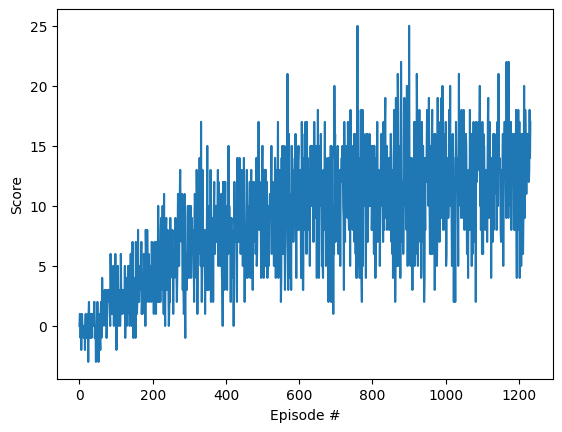

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [ ]:
env.close()

### Dueling Deep Q-Network

This is second attempt to improve the previous results, using a dueling q network implementation, and with the same hyper parameters. Looks like it reaches the goal using less episodes. The main difference is the dueling Q network, as you can see in the DuelingQnetwork in ddqn.py file, there is a first common layer to learn features from the staste, and then two separated streams to learn the value of state, and the advantage of each action.

The results shows that the algoritihm converges faster, even using the same hyper parameters than with the vanilla DQN algoritm, and the goal of average 13 points is reached in only 723 episodes.

In [1]:
# Hyper parameters
params = {
"BUFFER_SIZE" : int(1e6) , # replay buffer size.
"BATCH_SIZE" : 64        , # minibatch siz
"GAMMA" : 0.99           , # discount factor
"TAU" : 0.03             , # for soft update of target parameters
"LR" : 0.001             ,  # learning rate 
"UPDATE_EVERY" : 4       , # how often to update the network
"HIDDEN_1" : 256,
"HIDDEN_2" : 64,
"EPS_START": 1.0,
"EPS_END"  : 0.01,
"EPS_DECAY": 0.995
}

In [2]:
from ddqn import DuelingDQNAgent
from unityagents import UnityEnvironment
import torch
from train import train_rl

# please do not modify the line below
env = UnityEnvironment(file_name="./Banana_Linux_NoVis/Banana.x86_64")

# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

env_info = env.reset(train_mode=True)[brain_name] # reset the environment
state = env_info.vector_observations[0]            # get the current state
agent = DuelingDQNAgent(len(env_info.vector_observations[0]), brain.vector_action_space_size, 0, device,  **params)

scores = train_rl(env, agent, 2000, 1000, "checkpoint.pth", **params)

Found path: /home/jglara/DEV/RL/Value-based-methods/p1_navigation/./Banana_Linux_NoVis/Banana.x86_64
Mono path[0] = '/home/jglara/DEV/RL/Value-based-methods/p1_navigation/./Banana_Linux_NoVis/Banana_Data/Managed'
Mono config path = '/home/jglara/DEV/RL/Value-based-methods/p1_navigation/./Banana_Linux_NoVis/Banana_Data/MonoBleedingEdge/etc'
Preloaded 'libgrpc_csharp_ext.x64.so'
Unable to preload the following plugins:
	libgrpc_csharp_ext.x86.so
Logging to /home/jglara/.config/unity3d/Unity Technologies/Unity Environment/Player.log


INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: BananaBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 37
        Number of stacked Vector Observation: 1
        Vector Action space type: discrete
        Vector Action space size (per agent): 4
        Vector Action descriptions: , , , 


Episode 100	Average Score: 1.09
Episode 200	Average Score: 3.37
Episode 300	Average Score: 5.95
Episode 400	Average Score: 9.00
Episode 500	Average Score: 11.30
Episode 600	Average Score: 11.79
Episode 700	Average Score: 11.86
Episode 800	Average Score: 12.71
Episode 823	Average Score: 13.01
Environment solved in 723 episodes!	Average Score: 13.01


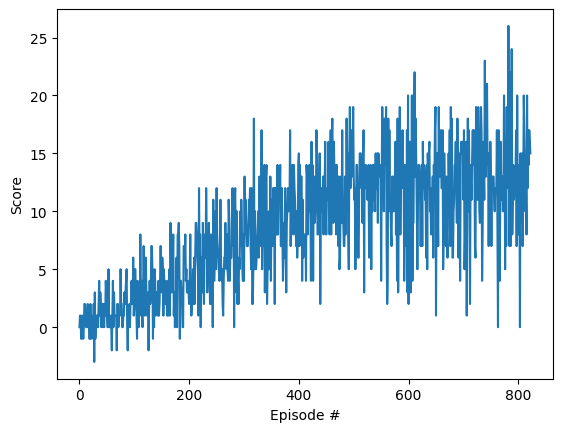

In [4]:
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

# plot the scores
fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(len(scores)), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

In [3]:
env.close()